
# Understanding the Radiometric Effects on Multispectral and Hyperspectral Satellite Images — **Lab 2** (DDL: 13 November 2025)
-- Ritu Yadav

> You will work in **Google Colab** or **Jupyter** using the **Earth Engine Python API** and **geemap** for interactive maps.



## Objective
The purpose of this lab is to understand the radiometric effects on multispectral and hyperspectral satellite images and how to perform radiometric correction.



## Background: some basic concepts for the lab

**Reflectance**  
Reflectance is the proportion of the radiation striking a surface to the radiation reflected off of it. Various land covers (urban, forest, water, etc.) can be identified by their reflectance spectra, so it is common to correct an image to reflectance as a first step toward locating or identifying features in an image.

**Top of Atmosphere (TOA) Reflectance**
TOA is the reflectance measured by a satellite sensor flying higher than the earth's atmosphere. These reflectance values include contributions from clouds and atmospheric aerosols and gases.

**Top of Atmosphere (TOA) Reflectance**
Also known as the surface reflectance, is the satellite derived Top of atmosphere (TOA) reflectance corrected for the scattering and absorption effects of atmospheric gases and aerosols.



## Pre-lab requirements (complete **before** the lab starts)
- Create (or verify) a Google account (e.g., `abcdef@gmail.com`).
- Register for a GEE account at <https://earthengine.google.com/signup/>.
- **Python environment:** Use **Google Colab** (recommended) or local **Jupyter**.



---
# Part 0 — Python setup for Earth Engine & geemap
Run the next two cells **once at the top** of your notebook session (every new session in Colab).  
- The first cell installs required packages.  
- The second cell authenticates and initializes Earth Engine and sets up an interactive map.


In [20]:

# If running in Colab or a fresh Jupyter environment, install dependencies:
# (Re-run this cell at the start of each new session if packages are missing.)
%pip install --quiet earthengine-api geemap


Note: you may need to restart the kernel to use updated packages.


In [21]:
import ee, geemap

project_name = "kth-digital-image-processing"

# Authenticate on first use (opens a link in Colab). In local Jupyter, it will open a browser.
try:
    ee.Initialize(project = project_name)
    print("Earth Engine is already initialized.")
except Exception:
    ee.Authenticate()  # Follow the link and paste the code when prompted
    ee.Initialize(project = project_name)
    print("Earth Engine has been authenticated and initialized.")

# Create a map instance you can reuse throughout the lab
Map = geemap.Map()
Map



Successfully saved authorization token.
Earth Engine has been authenticated and initialized.


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…


---
# Part 1 Plot Landsat 8 TOA reflectance at several locations

- Visualize the Landsat image (TOA, BOA) over Stockholm

In [22]:
import ee
import geemap

m = geemap.Map()

# Load Landsat 8 TOA, BOA
landsat8_toa = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
landsat8_boa = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

DATE_START = '2018-07-16'
DATE_END = '2018-07-17'

#Define ROI
Stockholm = ee.Geometry.Rectangle([
17.72070427694454, 59.8403518782597,
18.482880790616417, 59.14110025780542])

m.centerObject(Stockholm)
m.addLayer(Stockholm, {}, 'Stockholm')
# filter Landsat-8 TOA Image

l8_toa = (
    landsat8_toa
    .filterBounds(Stockholm)
    .filterDate(DATE_START, DATE_END)
    .mosaic()
    .select(['B[0-9]+'])  
)

l8_boa = (
    landsat8_boa
    .filterBounds(Stockholm)
    .filterDate(DATE_START, DATE_END)
    .mosaic()
    .select(['SR_B[0-9]+'])  
)

m.addLayer(l8_toa, {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3}, 'l8_toa')
m.addLayer(l8_boa, {"bands": ['SR_B4', 'SR_B3', 'SR_B2'], "min": 6000, "max": 12000}, 'l8_boa')

m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

- Analyse the band reflectances using inspecter tool on the right top cornor of geemap,
- pick a point and plot the reflectance

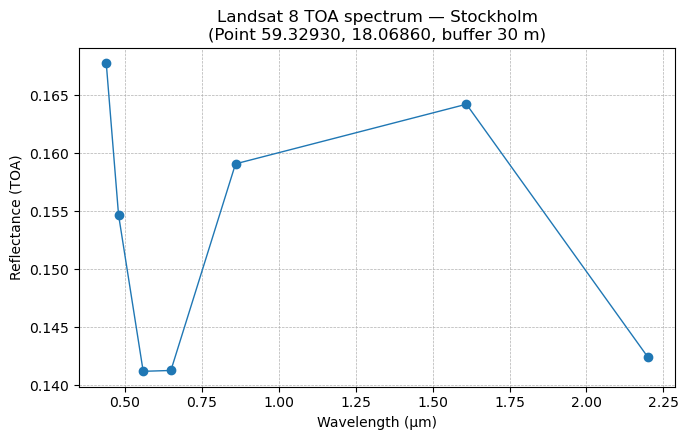

In [23]:
import ee
import matplotlib.pyplot as plt

# --- User settings (change if desired) ---
POINT_COORDS = (18.0686, 59.3293)   # (lon, lat) click inspector tool anywhere on stockholm and use correponding lon, lat
BUFFER_M = 30        # buffer radius in meters around the point to average
SCALE = 30           # Landsat pixel size in meter
point = ee.Geometry.Point(POINT_COORDS)
region = point.buffer(BUFFER_M)  # small circular region (buffer) to reduce noises
# ------------------------------------------------

# Bands of interest (TOA): B1..B7 correspond to wavelengths below
bands_l8_toa = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
wavelengths_l8 = [0.44, 0.48, 0.56, 0.65, 0.86, 1.61, 2.2] # Wavelengths (micrometers)

# Filter the collection and mosaic
l8_toa = landsat8_toa.filterBounds(point).filterDate(DATE_START, DATE_END).mosaic()

# Select the reflectance bands (first 7)
reflectance_toa = l8_toa.select(bands_l8_toa)

# Reduce region to mean reflectance over the buffered area
reducer = ee.Reducer.mean()
reduced = reflectance_toa.reduceRegion(reducer=reducer, geometry=region, scale=SCALE, maxPixels=1e9)

# Get values to the client
vals_dict = reduced.getInfo()

# Extract values in the same order as 'bands' and handle missing values
reflectance_values = []
for b in bands_l8_toa:
    v = vals_dict.get(b)
    if v is None:
        # If a band is missing, use NaN
        import math
        v = float('nan')
    reflectance_values.append(float(v))

# Plotting
plt.figure(figsize=(7,4.5))
plt.plot(wavelengths_l8, reflectance_values, marker='o', linewidth=1)
plt.title('Landsat 8 TOA spectrum — Stockholm\n(Point {:.5f}, {:.5f}, buffer {} m)'.format(POINT_COORDS[1], POINT_COORDS[0], BUFFER_M))
plt.xlabel('Wavelength (µm)')
plt.ylabel('Reflectance (TOA)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


You can examine temperature (band 10, 11) of different landcovers

-fetch the temperature (Band 10) of the point/polygon

In [24]:
# --- Fetch Band 10 Temperature (Brightness Temperature, TOA, in Kelvin) ---
band10 = l8_toa.select('B10')

temp_value = band10.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=SCALE,
    maxPixels=1e9
).get('B10').getInfo()

print("Band 10 Brightness Temperature (Kelvin):", temp_value)


Band 10 Brightness Temperature (Kelvin): 305.881548401035



---
# Part 2: Landsat 8 TOA vs BOA reflectance of several land cover types

- Visualize the Landsat image BOA over Stockholm

In [25]:
import ee
import geemap

m = geemap.Map()

# Load Landsat 8 BOA
landsat8_boa = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

m.centerObject(Stockholm)
m.addLayer(Stockholm, {}, 'Stockholm')
# filter Landsat-8 BOA Image
l8_boa = landsat8_boa.filterBounds(Stockholm).filterDate(DATE_START, DATE_END).mosaic()
m.addLayer(l8_boa, {"bands": ['SR_B4', 'SR_B3', 'SR_B2'], "min": 6000, "max": 12000}, 'l8_boa')

m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

Plot diagrams on the spectral response of the five small Regions of Interest (ROI) collected in the areas of water, urban, forest, vegetated agricultural fields and bare fields respectively. Compare the spectral response of TOA and BOA
- Spectral response plot of TOA

Option (A) : Draw different landcovers in above geemap, name the drawn features, extract the polygon and plot the reflectance.

In [26]:
# Get the drawn features (list of ee.Feature)
features = m.draw_features

# Convert each ee.Feature to ee.Geometry
polygons = [f.geometry() for f in features]

# Label them
landcover_dict = {f"Polygon_{i+1}": poly for i, poly in enumerate(polygons)}
# print(landcover_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


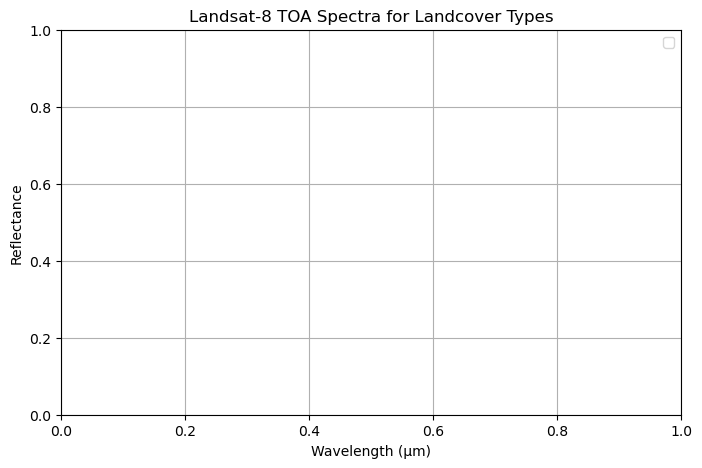

In [27]:
def extract_reflectance(image, bands, polygons):
    """Compute mean reflectance for each polygon and return dict."""
    results = {}
    for name, poly in polygons.items():
        stats = image.select(bands).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=poly,
            scale=30
        )
        results[name] = stats.getInfo()
    return results

# # Landsat-8 TOA
l8_toa_vals = extract_reflectance(l8_toa, bands_l8_toa, landcover_dict)

plt.figure(figsize=(8,5))
for lc_name, values in l8_toa_vals.items():
    y = [values[b] for b in bands_l8_toa]
    plt.plot(wavelengths_l8, y, marker='o', label=f'{lc_name} TOA')

plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Landsat-8 TOA Spectra for Landcover Types")
plt.legend()
plt.grid(True)
plt.show()

Option (B) : Define the polygons explicitly for each landcover and then plot.

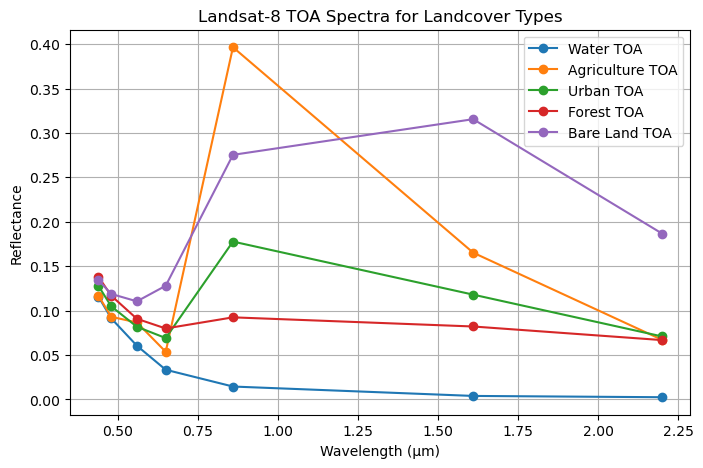

In [28]:
# Create polygons for different landcover types
forest = ee.Geometry.Polygon([[[18.06, 59.33], [18.07, 59.33], [18.07, 59.32], [18.06, 59.32]]])
agriculture = ee.Geometry.Polygon([[[17.889, 59.066], [17.889, 59.067], [17.893, 59.067], [17.893, 59.066]]])
urban = ee.Geometry.Polygon([[[18.06, 59.31], [18.07, 59.31], [18.07, 59.30], [18.06, 59.30]]])
water = ee.Geometry.Polygon([[[18.24, 59.02], [18.24, 59.05], [18.30, 59.05], [18.30, 59.02]]])
bare_land = ee.Geometry.Polygon([[[17.861, 59.546], [17.861, 59.547], [17.865, 59.547], [17.865, 59.546]]])

landcover_dict = {
    "Water": water,
    "Agriculture": agriculture,
    "Urban": urban,
    "Forest": forest,
    "Bare Land": bare_land,
}

def extract_reflectance(image, bands, polygons):
    """Compute mean reflectance for each polygon and return dict."""
    results = {}
    for name, poly in polygons.items():
        stats = image.select(bands).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=poly,
            scale=30
        )
        results[name] = stats.getInfo()
    return results

# # Landsat-8 TOA
l8_toa_vals = extract_reflectance(l8_toa, bands_l8_toa, landcover_dict)

plt.figure(figsize=(8,5))
for lc_name, values in l8_toa_vals.items():
    y = [values[b] for b in bands_l8_toa]
    plt.plot(wavelengths_l8, y, marker='o', label=f'{lc_name} TOA')

plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Landsat-8 TOA Spectra for Landcover Types")
plt.legend()
plt.grid(True)
plt.show()

- Spectral response plot of BOA

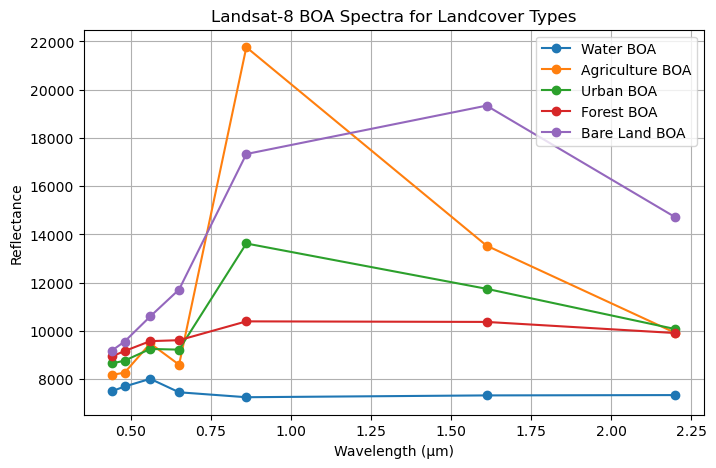

In [29]:
# Select surface reflectance bands (B1 to B7)
bands_l8_boa = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
reflectance_boa = l8_boa.select(bands_l8_boa)

# # Landsat-8 BOA
l8_boa_vals = extract_reflectance(l8_boa, bands_l8_boa, landcover_dict)

plt.figure(figsize=(8,5))
for lc_name, values in l8_boa_vals.items():
    y = [values[b] for b in bands_l8_boa]
    plt.plot(wavelengths_l8, y, marker='o', label=f'{lc_name} BOA')

plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Landsat-8 BOA Spectra for Landcover Types")
plt.legend()
plt.grid(True)
plt.show()

# Part 3: Visualize Sentinel-2 MSI top-of-atmosphere (TOA), bottom-of- atmosphere (BOA) and EO-1 Hyperion imagery over Stockholm

In [32]:
# Sentinel-2 TOA
s2_toa = (ee.ImageCollection("COPERNICUS/S2")
          .filterBounds(Stockholm)
          .filterDate("2018-07-10", "2018-07-26")
          .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 2))
          .median())
bands_s2_toa = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

# Sentinel-2 BOA (Surface Reflectance)
s2_boa = (ee.ImageCollection("COPERNICUS/S2_SR")
          .filterBounds(Stockholm)
          .filterDate("2018-07-10", "2018-07-26")
          .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 2))
          .median())
bands_s2_boa = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
wavelengths_s2 = [0.443,0.490,0.560,0.665,0.705,0.740,0.783,0.842,0.865,1.610,2.190]

# Hyperion
eo1_toa = ee.Image("EO1/HYPERION/EO1H1920182008186110P0_SGS_01")
bands_hyperion = eo1_toa.bandNames().getInfo()  # Hyperion has hundreds of band

In [33]:
# Sentinel-2 (10m)
s2_rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.2}
s2_nir_vis = {'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 3000, 'gamma': 1.2}

s2_rgb_vis_boa = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.2}
s2_nir_vis_boa = {'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 3000, 'gamma': 1.2}

# -------------------------
# EO-1 Hyperion [30m]
eo1_bandnames = eo1_toa.bandNames().getInfo()
print("Hyperion band count:", len(eo1_bandnames))

hyperion_rgb_vis = {'bands': ['B031', 'B021', 'B015'], 'min': 0, 'max': 5000}
hyperion_nir_vis = {'bands': ['B048', 'B031', 'B021'], 'min': 0, 'max': 5000}

# Maplayers
centroid = Stockholm.centroid().coordinates().getInfo()[::-1]
m = geemap.Map(center=centroid, zoom=10)

# Add rectangle boundary for AOI
m.addLayer(ee.Image().paint(Stockholm, 1, 2), {'palette': 'red'}, 'Stockholm AOI boundary')

# Add Sentinel-2 TOA layers
m.addLayer(s2_toa, s2_rgb_vis, 'S2 TOA RGB (B4,B3,B2)')
m.addLayer(s2_toa, s2_nir_vis, 'S2 TOA NIR (B8,B4,B3)')

# Add Sentinel-2 BOA layers
m.addLayer(s2_boa, s2_rgb_vis_boa, 'S2 BOA (SR) RGB (B4,B3,B2)')
m.addLayer(s2_boa, s2_nir_vis_boa, 'S2 BOA (SR) NIR (B8,B4,B3)')

# Add EO-1 Hyperion (example composite)
m.addLayer(eo1_toa, hyperion_rgb_vis, 'Hyperion example RGB (B031,B021,B015)')
m.addLayer(eo1_toa, hyperion_nir_vis, 'Hyperion example NIR (B048,B031,B021)')

# Add layer control and display
m.addLayerControl()
m

Hyperion band count: 198


Map(center=[59.490073514340054, 18.101792533780127], controls=(WidgetControl(options=['position', 'transparent…

# Part 4: Plot Sentinel-2 TOA and BOA reflectance of several land cover types

In [34]:
# Sentinel-2 TOA and BOA
s2_toa_vals = extract_reflectance(s2_toa, bands_s2_toa, landcover_dict)
s2_boa_vals = extract_reflectance(s2_boa, bands_s2_boa, landcover_dict)

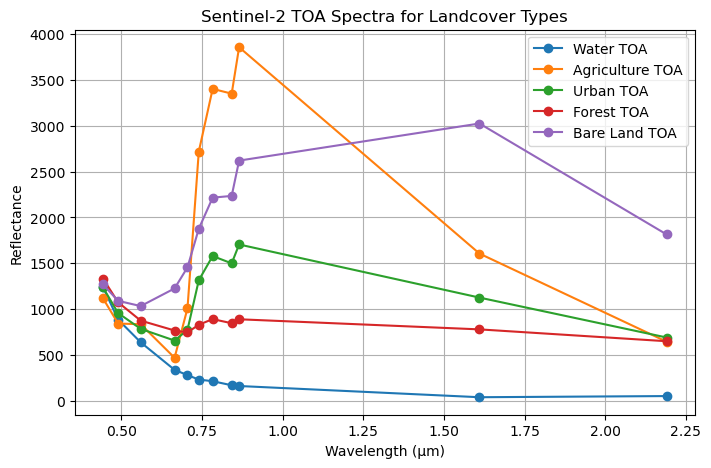

In [35]:
plt.figure(figsize=(8,5))
for lc_name, values in s2_toa_vals.items():
    y = [values[b] for b in bands_s2_toa]
    plt.plot(wavelengths_s2, y, marker='o', label=f'{lc_name} TOA')

plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Sentinel-2 TOA Spectra for Landcover Types")
plt.legend()
plt.grid(True)
plt.show()


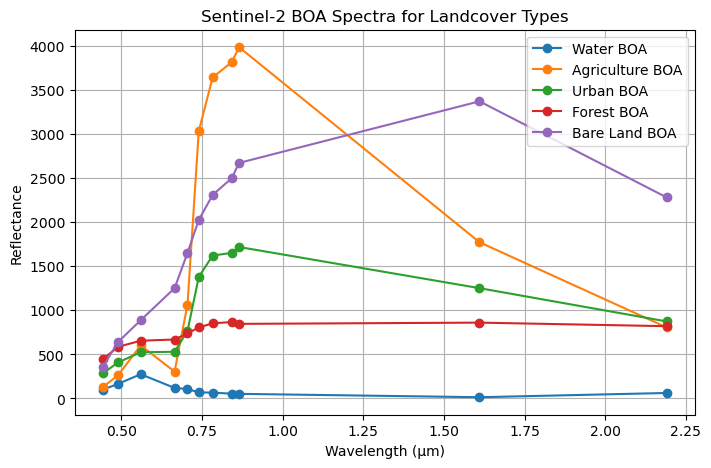

In [36]:
plt.figure(figsize=(8,5))
for lc_name, values in s2_boa_vals.items():
    y = [values[b] for b in bands_s2_boa]
    plt.plot(wavelengths_s2, y, marker='o', label=f'{lc_name} BOA')

plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Sentinel-2 BOA Spectra for Landcover Types")
plt.legend()
plt.grid(True)
plt.show()


# Part 5: Plot EO-1 Hyperion TOA reflectance of several land cover types

Note: Remember to pick the landcover point/polygon within Hyperion image coverage.

In [43]:
import numpy as np

In [44]:
# EO-1 Hyperion
eo1_toa = ee.Image("EO1/HYPERION/EO1H1920182008186110P0_SGS_01")
bands_hyperion = eo1_toa.bandNames().getInfo()  # Hyperion has hundreds of band
hyperion_vals = extract_reflectance(eo1_toa, bands_hyperion, landcover_dict)
hyp_wavelengths = [426.8200, 436.9900, 447.1700, 457.3400, 467.5200, 477.6900, 487.8700, 498.0400, 508.2200, 518.3900, 528.5700, 538.7400, 548.9200, 559.0900, 569.2700, 579.4500, 589.6200, 599.8000, 609.9700, 620.1500, 630.3200, 640.5000, 650.6700, 660.8500, 671.0200, 681.2000, 691.3700, 701.5500, 711.7200, 721.9000, 732.0700, 742.2500, 752.4300, 762.6000, 772.7800, 782.9500, 793.1300, 803.3000, 813.4800, 823.6500, 833.8300, 844.0000, 854.1800, 864.3500, 874.5300, 884.7000, 894.8800, 905.0500, 915.2300, 925.4100, 912.4500, 922.5400, 932.6400, 942.7300, 952.8200, 962.9100, 972.9900, 983.0800, 993.1700, 1003.300,1013.300, 1023.400,1033.490,1043.590, 1053.690, 1063.790, 1073.890, 1083.990, 1094.090, 1104.190, 1114.190, 1124.280,1134.3800, 1144.4800, 1154.5800, 1164.6800, 1174.7700, 1184.8700, 1194.9700, 1205.0700, 1215.1700, 1225.1700, 1235.2700, 1245.3600, 1255.4600, 1265.5600, 1275.6600, 1285.7600, 1295.8600, 1305.9600, 1316.0500, 1326.0500, 1336.1500, 1346.2500, 1356.3500, 1366.4500, 1376.5500, 1386.6500, 1396.7400, 1406.8400, 1416.9400, 1426.9400, 1437.0400, 1447.1400, 1457.2300, 1467.3300, 1477.4300, 1487.5300, 1497.6300, 1507.7300, 1517.8300, 1527.9200, 1537.9200, 1548.0200, 1558.1200, 1568.2200, 1578.3200, 1588.4200, 1598.5100, 1608.6100, 1618.7100, 1628.8100, 1638.8100, 1648.9000, 1659.0000, 1669.1000, 1679.2000, 1689.3000, 1699.4000, 1709.5000, 1719.6000, 1729.7000, 1739.7000, 1749.7900, 1759.8900, 1769.9900, 1780.0900, 1790.1900, 1800.2900, 1810.3800, 1820.4800, 1830.5800, 1840.5800, 1850.6800, 1860.7800, 1870.8700, 1880.9800, 1891.0700, 1901.1700, 1911.2700, 1921.3700, 1931.4700, 1941.5700, 1951.5700, 1961.6600, 1971.7600, 1981.8600, 1991.9600, 2002.0600, 2012.1500, 2022.2500, 2032.3500, 2042.4500, 2052.4500, 2062.5500, 2072.6500, 2082.7500, 2092.8400, 2102.9400, 2113.0400, 2123.1400, 2133.2400, 2143.3400, 2153.3400, 2163.4300, 2173.5300, 2183.6300, 2193.7300, 2203.8300, 2213.9300, 2224.0300, 2234.1200, 2244.2200, 2254.2200, 2264.3200, 2274.4200, 2284.5200, 2294.6100, 2304.7100, 2314.8100, 2324.9100, 2335.0100, 2345.1100, 2355.2100, 2365.2000, 2375.3000, 2385.4000, 2395.5000]
hyp_wavelengths_scaled = np.array(hyp_wavelengths) / 1000.0 

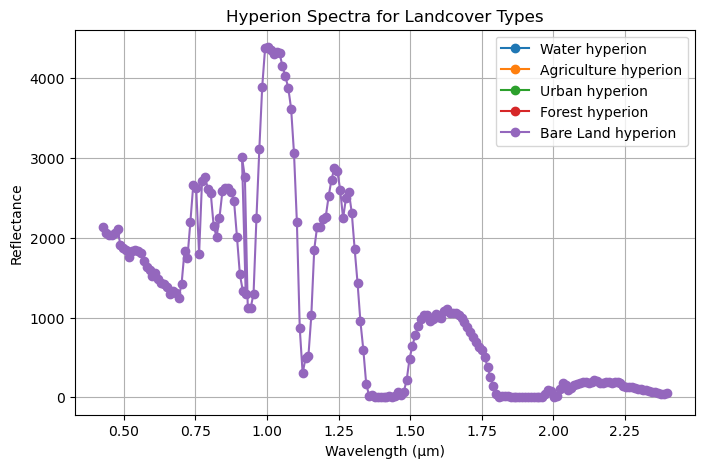

In [45]:
plt.figure(figsize=(8,5))
for lc_name, values in hyperion_vals.items():
    y = [values[b] for b in bands_hyperion]
    plt.plot(hyp_wavelengths_scaled, y, marker='o', label=f'{lc_name} hyperion')


plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Hyperion Spectra for Landcover Types")
plt.legend()
plt.grid(True)
plt.show()
